In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
data = pd.read_csv('../datasets/input.csv')
target = pd.read_csv('../datasets/target.csv')

In [4]:
datasets = pd.merge(data, target, on=('국가별', '시점'), how='outer')
datasets.dropna(inplace=True)
datasets.reset_index(inplace=True)
datasets.drop(['국가별', 'index'], axis=1, inplace=True)
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시점        1261 non-null   int64  
 1   인당_GDP    1261 non-null   float64
 2   부채비율      1261 non-null   float64
 3   실업률       1261 non-null   float64
 4   상품및서비스수입  1261 non-null   float64
 5   상품및서비스수출  1261 non-null   float64
 6   정치적안정성    1261 non-null   int64  
 7   규제의질      1261 non-null   int64  
 8   경상수지      1261 non-null   float64
 9   신용등급점수    1261 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 98.6 KB


In [5]:
lb = LabelEncoder()
datasets['시점'] = lb.fit_transform(datasets['시점'])
datasets.describe()

,시점,인당_GDP,부채비율,실업률,상품및서비스수입,상품및서비스수출,정치적안정성,규제의질,경상수지,신용등급점수
count,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000
mean,7.505155,22012.779330,55.695265,7.113140,4.170044,3.660556,54.612213,67.015860,-1.326674,12.526324
std,4.603761,22939.181148,37.783440,4.499929,10.071854,9.109875,27.897707,23.512842,7.070186,5.288810
min,0.000000,333.731576,-3.400000,0.210000,-50.275895,-56.736571,0.000000,6.000000,-41.526871,0.000000
25%,4.000000,4379.658787,30.300000,4.120000,0.200224,0.259701,29.000000,48.000000,-4.754963,8.000000
50%,8.000000,12808.038340,47.100000,6.120000,4.560764,4.075288,58.000000,70.000000,-1.742977,12.500000
75%,11.000000,36323.447740,70.780000,8.480000,9.093538,7.668103,79.000000,88.000000,2.367691,17.000000
max,15.000000,123514.196700,266.200000,31.110000,66.893243,86.043298,100.000000,100.000000,27.397650,20.000000


In [369]:
# datasets.iloc[:,9] = (round(datasets.iloc[:,9])).astype(int)
# datasets['신용등급점수'] = datasets['신용등급점수'].apply(lambda x: 4 if x<4 else x)

In [6]:
datasets.iloc[:,9] = (round(datasets.iloc[:,9]).astype(int)).astype(str)
# datasets.iloc[:,9] = datasets.iloc[:,9].apply(lambda x: math.trunc(x))
# datasets.iloc[:,9] = datasets.iloc[:,9].astype(str)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(datasets.iloc[:,:9], datasets.iloc[:,9], test_size=0.2, random_state=42)

In [8]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

In [9]:
len(np.unique(y_train)), len(np.unique(y_test))

(20, 20)

In [10]:
lb = LabelEncoder()
#y_train = lb.fit_transform(y_train)
y_train = pd.get_dummies(y_train).values
#y_train = sequence.pad_sequences(y_train, maxlen=20)
#y_test = lb.fit_transform(y_test)
y_test = pd.get_dummies(y_test).values
#y_test = sequence.pad_sequences(y_test, maxlen=20)

In [11]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1008, 9), (253, 9), (1008, 20), (253, 20))

In [16]:
tf.random.set_seed(42)
model = Sequential()

model.add(Dense(512,input_shape=(9,),activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(20,activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               5120      
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 20)                2580      
                                                                 
Total params: 73,364
Trainable params: 73,364
Non-trainable params: 0
_________________________________________________________________


In [17]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test Accuracy: %.4f' % (model.evaluate(x_test, y_test)[1]))


Epoch 1: val_loss improved from inf to 2.25917, saving model to ./model\01-2.259171.hdf5

Epoch 2: val_loss improved from 2.25917 to 2.01966, saving model to ./model\02-2.019656.hdf5

Epoch 3: val_loss improved from 2.01966 to 1.89116, saving model to ./model\03-1.891159.hdf5

Epoch 4: val_loss improved from 1.89116 to 1.79965, saving model to ./model\04-1.799648.hdf5

Epoch 5: val_loss improved from 1.79965 to 1.74846, saving model to ./model\05-1.748455.hdf5

Epoch 6: val_loss improved from 1.74846 to 1.72839, saving model to ./model\06-1.728395.hdf5

Epoch 7: val_loss improved from 1.72839 to 1.68024, saving model to ./model\07-1.680237.hdf5

Epoch 8: val_loss improved from 1.68024 to 1.66047, saving model to ./model\08-1.660468.hdf5

Epoch 9: val_loss improved from 1.66047 to 1.64090, saving model to ./model\09-1.640897.hdf5

Epoch 10: val_loss improved from 1.64090 to 1.61322, saving model to ./model\10-1.613225.hdf5

Epoch 11: val_loss improved from 1.61322 to 1.59288, saving mo

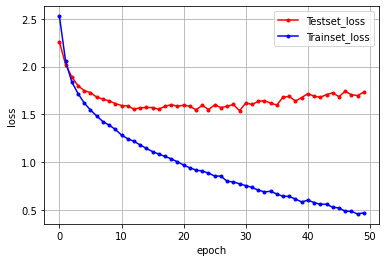

In [18]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

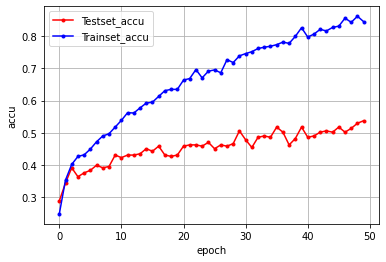

In [19]:
# 테스트 셋의 오차
y_vaccu = history.history['val_accuracy']

# 학습셋의 오차
y_accu = history.history["accuracy"]

# 그래프로 표현
x_len = np.arange(len(y_accu))
plt.plot(x_len, y_vaccu, marker=".", c="red", label="Testset_accu")
plt.plot(x_len, y_accu, marker=".", c="blue", label="Trainset_accu")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("accu")
plt.show()

## cross_val_score
##### https://talkingaboutme.tistory.com/entry/DL-%ED%95%B4%EB%B3%B4%EB%A9%B4%EC%84%9C-%EB%B0%B0%EC%9A%B0%EB%8A%94-%EB%94%A5%EB%9F%AC%EB%8B%9D-ANN-%ED%8F%89%EA%B0%80%ED%95%98%EA%B8%B0


In [20]:
def build_classifier():
    model = Sequential()

    model.add(Dense(512,input_shape=(9,),activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(20,activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                optimizer='Adam', 
                metrics=['accuracy'])

    model.summary()
    return model

In [22]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size=32, epochs=100)

accuracies = cross_val_score(estimator=classifier, X=x_train, y=y_train, cv=10, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               5120      
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dense_20 (Dense)            (None, 20)                2580      
                                                                 
Total params: 73,364
Trainable params: 73,364
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


C:\Users\dbswo\AppData\Local\Temp\ipykernel_18484\836544432.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier, batch_size=32, epochs=100)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


29/29 [==============================] - 0s 929us/step - loss: 2.5418 - accuracy: 0.2536
Epoch 2/100
29/29 [==============================] - 0s 1ms/step - loss: 2.0907 - accuracy: 0.3319
Epoch 3/100
29/29 [==============================] - 0s 929us/step - loss: 1.8788 - accuracy: 0.3815
Epoch 4/100
29/29 [==============================] - 0s 964us/step - loss: 1.7368 - accuracy: 0.4223
Epoch 5/100
29/29 [==============================] - 0s 857us/step - loss: 1.6312 - accuracy: 0.4388
Epoch 6/100
29/29 [==============================] - 0s 965us/step - loss: 1.5511 - accuracy: 0.4730
Epoch 7/100
29/29 [==============================] - 0s 893us/step - loss: 1.5041 - accuracy: 0.4697
Epoch 8/100
29/29 [==============================] - 0s 1ms/step - loss: 1.4301 - accuracy: 0.4950
Epoch 9/100
29/29 [==============================] - 0s 1ms/step - loss: 1.3879 - accuracy: 0.5061
Epoch 10/100
29/29 [==============================] - 0s 1ms/step - loss: 1.3291 - accuracy: 0.5248
Epoch 11/

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.4s finished


In [23]:
mean = accuracies.mean()
variance=accuracies.std()
mean, variance

(0.5089702993631363, 0.05558314592671918)